# Project 2: Hawkes Process
# Group W: Khair Mohamed - El Firdoussi Aymane - Msik Ahmed Amine

# I - Introduction: 


Named after Halan G.Hawkes, a Hawkes process is a self-exciting point process making arrival rate of events depending on past events. 
In this project, we study the time arrivals of cyber attacks, which we assume to be a Hawkes process. In this notebook, we will use a public dataset, "PRC.csv", that contains the dates of plenty of attacks, sorted by category and date of appearance. Our work will consist on maximizing the log-likelihood of our data, find the Hawkes parameters, compute its compensator in the arrival times of Hacks, and finally verify that these quantities correspond to a Poisson Process of intensity 1. To verify that, we will use several numerical methods such as density estimation, the Kullback-Leiber divergence and the Kolmogorov test and also by a graphical visualization. 

## Data preparation

Our work is based on the dataset from the Privacy Rights Clearinghouse (PRC). The data is comprised of publicly available information on reported breaches designed to help advocates, policymakers, journalists and researchers better understand reported data breaches in the United States.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize, root_scalar, LinearConstraint
import scipy.integrate as integrate
import seaborn as sns
from scipy.stats import expon

# All imports go here

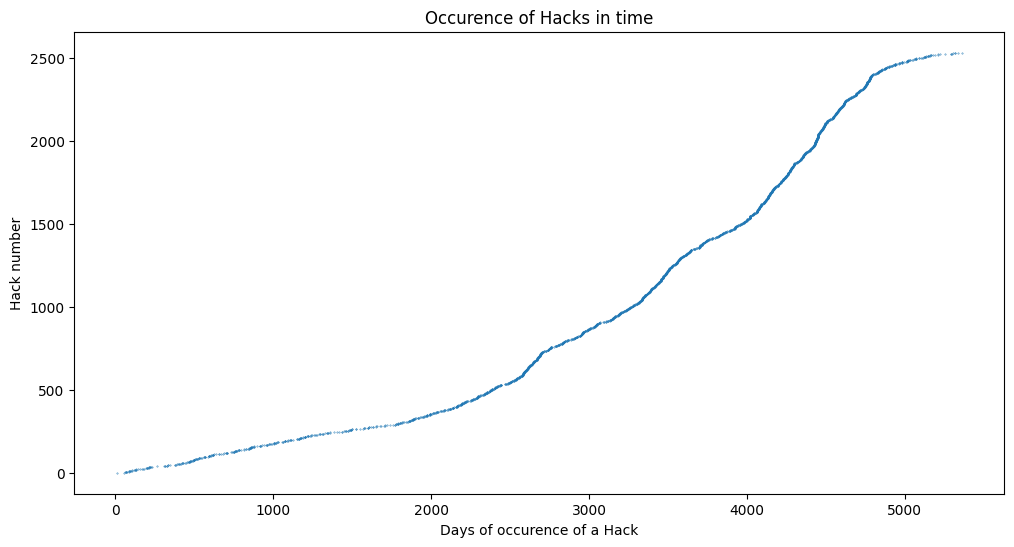

In [2]:
# Loading the data set
df = pd.read_csv("PRC.csv", sep=';')

# Taking the dates of HACKs
dff = df.loc[ df['Type of breach'] == "HACK", 'Date Made Public'] 
dff = dff.apply( lambda x:datetime.strptime(x, '%m/%d/%Y')) 

# Making the first date as 0
debut = min(dff) 
dff = dff - debut
dff = dff.apply(lambda x:x.days).sort_values()

# Sorting by date
l = np.asarray(dff)[1:]

# Plotting the 
plt.figure(figsize = (12, 6))
plt.scatter(l, 1 + np.arange(len(l)), s=0.1)
plt.xlabel("Days of occurence of a Hack")
plt.ylabel("Hack number")
plt.title("Occurence of Hacks in time")

plt.show()

This graph represents the total number of hacks that occured at any given day. Day 0 represents the first day where the data began to be collected in 2005. 

----
## II - Log-likelihood

The log-likelihood is given by:
$$ \log(L(N, t)) = \sum_{T_n \leq t} \log(\alpha + \beta \sum_{j = 1}^{n - 1} e^{- \gamma (T_n - T_j)}) + (1 - \alpha) t - \frac{\beta}{\gamma} \sum_{T_n \leq t}(1 - e^{\gamma(t - T_n)})  $$

Here is the function "log_likelihood" used to compute this formula taking $T$, $t$, $\alpha$, $\beta$, $\gamma$ as parameters.

In [68]:
def log_likelihood(T, t, alpha, beta, gamma):
    """
    input:
    T: the point process
    t: instant at which we compute the likelihood
    alpha, beta, gamma: parameters of the function
    
    output:
    The log-likelihood evaluated at time t
    """
    logL = (1 - alpha) * t
    n = 0
    N = len(T)
    while n < N and T[n] < t:
        logL -= beta * ( 1 - np.exp(-gamma * (t - T[n]))) /gamma
        s = np.sum(np.exp(- gamma * (T[n] - T[ : n])))    
        logL += np.log(alpha + beta * s)
        n += 1
    return logL

In [69]:
# example to make sure that our function works
print(log_likelihood(l, l[-1], 0.2941852637537663, 1005236.90706282625, 5002948.68611829698))

14887.672207717642


## Finding the parameters that maximize the log-likelihood

In the **scipy** library, there is a function called **minimize** that we can use in our optimization problem. But, since we have a maximization problem, we should find a way to transform it as a minimization problem. Thus, Maximizing the log-likelihood is equivalent to minimizing the negative log-likelihood, i.e:

$$ \arg \max_{\alpha, \beta, \gamma} \log(L(N, t)) =  \arg \min_{\alpha, \beta, \gamma} \: -\log(L(N, t))  $$
Under the constraints:
$$ \alpha, \beta, \gamma > 0 \: \: \: and \: \: \: \: \beta < \gamma $$


In [70]:
# Function to minimize 
def negative_log_likelihood(param, T, t):
    return  -log_likelihood(T, t, param[0], param[1], param[2])

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
# Paramaters
x0 = (0.5, 0.5, 1)
T = l
t = T[-1]

# The constraint beta < gamma
constraint = LinearConstraint([0, -1, 1], lb = 0, ub=np.inf, keep_feasible = False)

# Optimization
res = minimize(negative_log_likelihood, x0, method = "Nelder-Mead", args = (T, t),constraints = constraint,  bounds = ((0, None), (0, None),(0,None)), tol = 1e-30)
alpha_max = res.x[0]
beta_max = res.x[1]
gamma_max = res.x[2]
print("The optimal parameters are : \n ")
print("alpha : ", alpha_max)
print("Beta : ", beta_max)
print("Gamma : ", gamma_max)
print("the maximum is :", log_likelihood(T, t, alpha_max, beta_max, gamma_max)) 

The optimal parameters are : 
 
alpha :  0.303776732390097
Beta :  3.516009476662848e+28
Gamma :  3.456794375746127e+29
the maximum is : 64607.21980005921


We know that $$ \dot{y}(N, t) = \alpha + \beta \int_0^{t^-} e^{- \gamma (t - s)} \mathrm{d}N(s) = \alpha + \beta\sum_{T_n \leq t} e^{- \gamma (t - T_n)} $$

In [73]:
def y_dot(t, T, alpha, beta, gamma):
    n = 0
    N = len(T)
    s = 0

    # computing the sum
    while n < N and T[n] < t:
        s += np.exp(-gamma * (t - T[n]))
        n += 1
    return alpha + beta * s

$$ y(N, t) = \int_0^t \dot{y}(N, u) \mathrm{d}u  $$
And we want to compute the values of the sequence $(y(N, T_n(N)))_n$

In [74]:
def y(t, T, alpha, beta, gamma):
    return integrate.quad(lambda x: y_dot(x, T, alpha, beta, gamma) , 0, t)[0]

def process(T, alpha, beta, gamma):
    Y = []
    for i in range(len(T)):
        Y.append(y(T[i], T, alpha, beta, gamma))
    return np.array(Y)

def inter_arrivals(Y):
    return Y[1 :] - Y[ : -1]

#### Remark:
The following cell will take approximatly 1 min to compute the point process and the inter-arrivals.

In [75]:
Y = process(T, alpha_max, beta_max, gamma_max)
inter = inter_arrivals(Y)

In [77]:
print(Y)
print(inter)

[   2.80604431   19.99306572   21.04533234 ... 1866.37022309 1873.38533387
 1881.45271127]
[17.18702141  1.05226662  1.7537777  ...  0.35075554  7.01511078
  8.0673774 ]


----

# III- Verifying that the process $(y(N, T_n(N)))_n$ is Poisson of intensity 1

## First method: Graphical visualization
To verify graphically that the random variables comprising the process of inter-arrivals $(\xi_i)_{i \in {1, ..., N}}$ are of exponential law $\mathcal{E}(1)$, we can plot the histogram of their values and see if it has the same shape as the exponential density $f$ of parameter 1 $$ f(x) = e^{- x} \mathbb{1}_{x \geq 0} $$
We can also plot the kernel density estimation function, which we will precise its expression in the next method. 

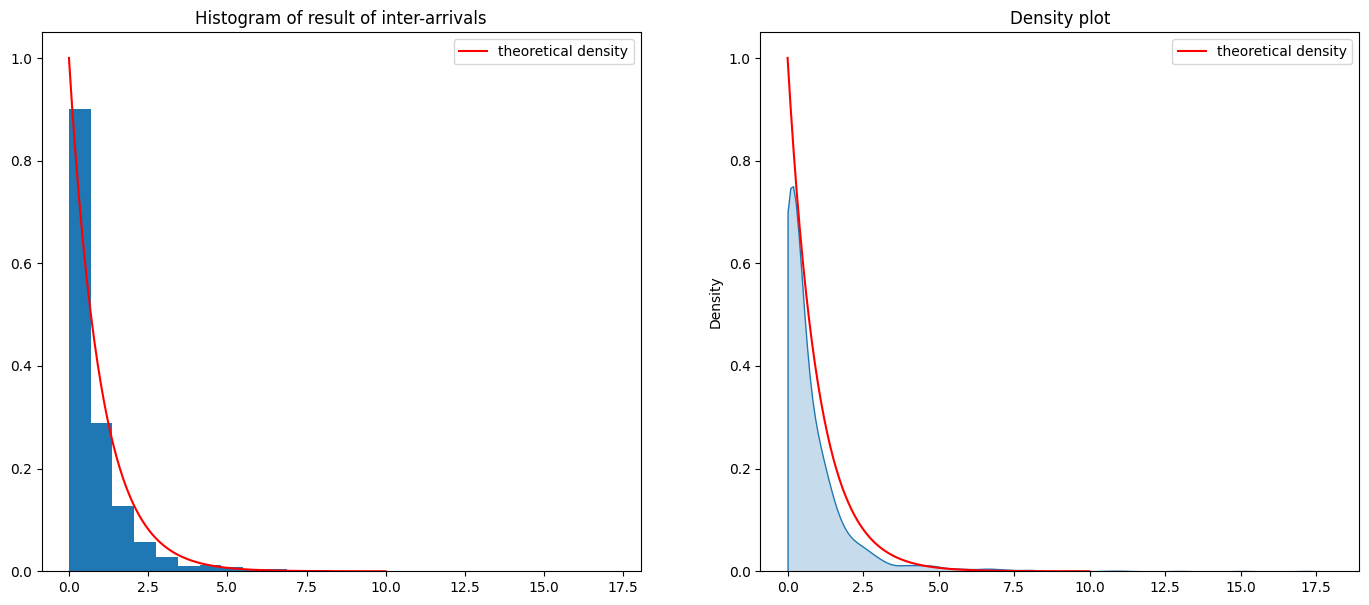

In [78]:
f = lambda x: np.exp(-x)
t = np.linspace(0, 10, 100)

# Plotting the comparisoon between densities
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(inter, density = True, bins = 25)
axs[0].set_title('Histogram of result of inter-arrivals')
axs[0].plot(t, f(t), label = 'theoretical density', c = 'r')
axs[0].legend()

# Plot the True density
sns.kdeplot(data = inter, fill=True, ax=axs[1], bw_method='silverman', clip=(0, None))
axs[1].plot(t, f(t), label = 'theoretical density', c = 'r')
axs[1].set_title('Density plot')
axs[1].legend()

# Show the plot
plt.show()

#### $$ \mathcal{Conclusion}$$
We can observe graphically that the inter-arrivals are actually of distribution $\mathcal{E}(1)$ because the histogram of values, as well as the kernel density estimator, have the same shape and behaviour as of the density of the exponential law.

----

## Second method: Test of Kolmogorov

A K-S test provides a way of comparing distributions, whether two sample distributions or a sample distribution with a theoretical distribution. Here we use it to compare our sample of inter-intervals with the exponential distribution. The distributions are compared in their cumulative form as Empirical Cumulative Distribution functions. It's based on the maximum vertical ditance between the two cumulative distributions.

In this section, we will use the One-sample K-S test that requires the specified distribution (in our example the exponential distribution) to be continuous. The empirical distribution that we use is 

$$ \hat{F}(x) = \sum_{i=1}^{n} \frac{{\text{{number of observations}} \leq x}}{{\text{{total number of observations}}}} $$

In [79]:
def empirical_cdf(X, t):
    N = len(X)
    mask = X < t
    return len(X[mask]) / N

def exp_cdf(t):
    return 1 - np.exp(-t)

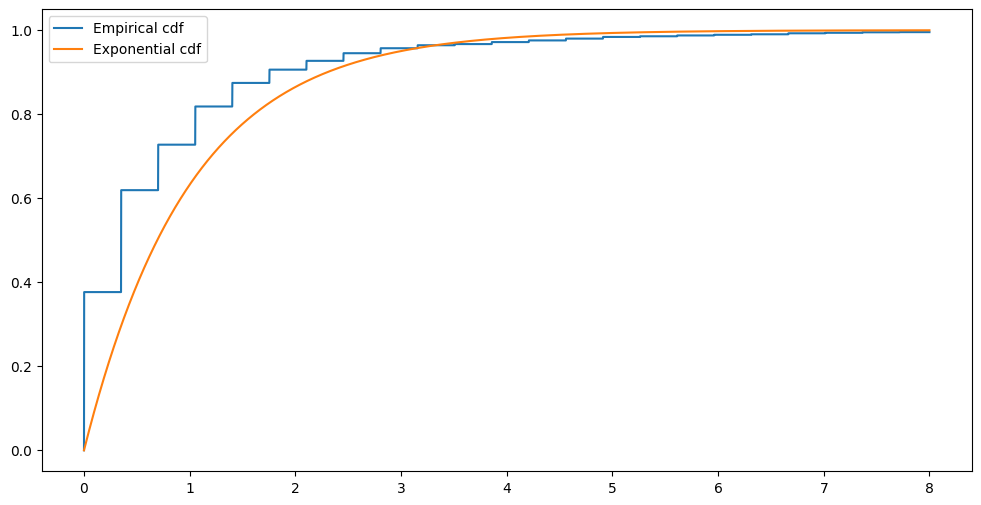

In [80]:
# Plotting the empirical density and the true one
t = np.linspace(0, 8, 10000)
plt.figure(figsize=(12, 6))

# Empirical cdf
values = []
for k in t:
    values.append(empirical_cdf(inter, k))
plt.plot(t, values, label = 'Empirical cdf')

# True cdf
plt.plot(t, exp_cdf(t), label = 'Exponential cdf')
plt.legend()
plt.show()

In general, if we consider, as a reference distribution, the cumulative distribution function $F_0$ of an exponential law of parameter 1, and we observe an independent and identically distributed samples $X_{1:n} = (X_1, \ldots, X_n)$, for which we denote the common cumulative distribution function as $F$. We want to test the hypotheses:

$H_0: F = F_0$ against $H_1: F \neq F_0$

Naturally, we will use the following test statistic:

$$h_n(X_{1:n}, F_0) = || F_n - F_0 ||_{\infty}.$$

If we assume $F_0$ and $F$ to be continuous, we get:

$$h_n(X_{1:n}, F_0)  = \max_{1 \leq j \leq n} \{ \max(\frac{j}{n} - F_0(X_j), F_0(X_j) - \frac{j - 1}{n}) \} .$$

In [81]:
# Sort the array
sorted_inter = sorted(inter)
n = len(sorted_inter)

# calculate the test statistic
test_statistic = 0
for j in range(n):
    max_val = max((j + 1) / n - expon.cdf(sorted_inter[j], scale = 1), expon.cdf(sorted_inter[j], scale = 1) - j / n)
    if max_val >= test_statistic:
        test_statistic = max_val
print("The value of our test statistic is : ", test_statistic)

The value of our test statistic is :  0.3765310154089293


We then compute the p-value of our test to see if we should reject $H_0$. If the p-value is not close to 0, then we shouldn't reject the null hypothesis. If we denote by $h^*$ the value of our test statistic, then the expression of the p-value is given by:

$$p_{value} =\mathbb{P}_{H_0}[h_n(X_{1:n}, F_0) \geq h^*] = 1 - F_0(h^*)$$

In [82]:
#calculate the p-value
p_value = 1.0 - expon.cdf(test_statistic)

# Print the test results
print("Test statistic: ",test_statistic)
print("P-value: " , p_value)

Test statistic:  0.3765310154089293
P-value:  0.6862378334096746


#### $$\mathcal{Conclusion}$$
The Kolmogorov test showed us that the distribtuion of the random variables $(\xi_i)_{i \in \{1, .., N \}}$ is very likely to be an exponential distribution of parameter 1, which verifies our previous methods because of the p-value of 0,68.

----

## Third method: Kernel estimator

Given a set of random variables $(X_i)_{i \in \{1, ..., N \}}$ following the same distribution with common density $f$, we define the kernel estimator of the density $f$ by:
$$ \hat{f}(x) = \frac{1}{N h} \sum_{i = 1}^{N} K \left(\frac{X_i - x}{h} \right) $$
Where $h > 0$ and $K$ is a symmetric positive definite kernel, i.e, $\forall \alpha_1, ..., \alpha_n \in \mathbb{R}$ and $\forall x_1, ..., x_n \in \mathbb{R}^d$ we have that:
$$  \sum_{i = 1}^n \sum_{j = 1}^n \alpha_i \alpha_j K(x_i - x_j) \geq 0 $$

$\hat{f}$ is an estimate of the true density $f$. To evaluate its accuracy, we will use different metrics that we will specify below.

In [83]:
# The Kernel density estimation
def kde_gauss(X, h, t):
    """
    X : the list of random variables
    h : the window size
    t : the instant in which we want to compute the estimation
    """
    N = len(X)
    s = 0
    for i in range(N):
        s += np.exp(-(X[i] - t)**2 / h**2)
    return s /(N * h)

### Plotting the kernel density estimator and the true density

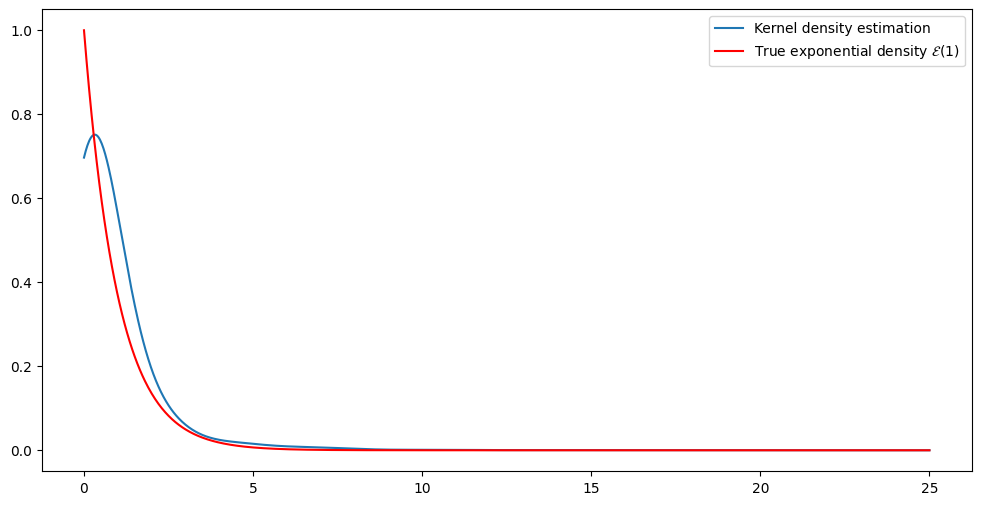

In [98]:
# Plotting the kernel density estimation
h = 1
plt.figure(figsize=(12, 6))
t = np.linspace(0, 25, 1000)
plt.plot(t, kde_gauss(inter, h, t), label = 'Kernel density estimation')

# Plotting the true exponential density
f = lambda x: np.exp(-x)
plt.plot(t, f(t), c = 'r', label = 'True exponential density $\mathcal{E}(1)$')
plt.legend()
plt.show()

#### Performance metrics:

To measure the performance of this estimator, we can use two metrics:
- The $L^2$ norm between the functions, which is defined by: $$ \| \hat{f} - f \|_2 = \left(\int (\hat{f}(x) - f(x))^2 \mathrm{d}x \right )^{\frac{1}{2}} $$
- The $R^2$ score (known also as the determination coefficient), which is a Machine Learning metric used to compute the accuracy of a model to estimate an output in $\mathbb{R}$ in a regression task. This score is given by:
$$ R^2(f, \hat{f}) = 1 - \frac{\sum_{i = 1}^N (\hat{f}(X_i) - f(X_i))^2}{\sum_{i = 1}^N (f(X_i) - \bar{f})^2} $$
Where : $\bar{f} = \frac{1}{N} \sum_{i = 1}^Nf(X_i)$ and $(X_i)_{i = 1}^N$ are samples from the exponential law $\mathcal{E}(1)$

In [99]:
# Compute the difference between f(x) and g(x)
def L_2(f, g, a, b):
    difference = integrate.quad(lambda x: (f(x) - g(x))**2 ,a ,b)[0]
    return np.sqrt(difference)

def R_2(f, g, X):
    mean = np.mean(f(X))
    return 1 - np.sum((f(X) - g(X))**2) / np.sum((f(X) - mean)**2)


The $L^2$ norm of the difference is :  0.23726475166176703


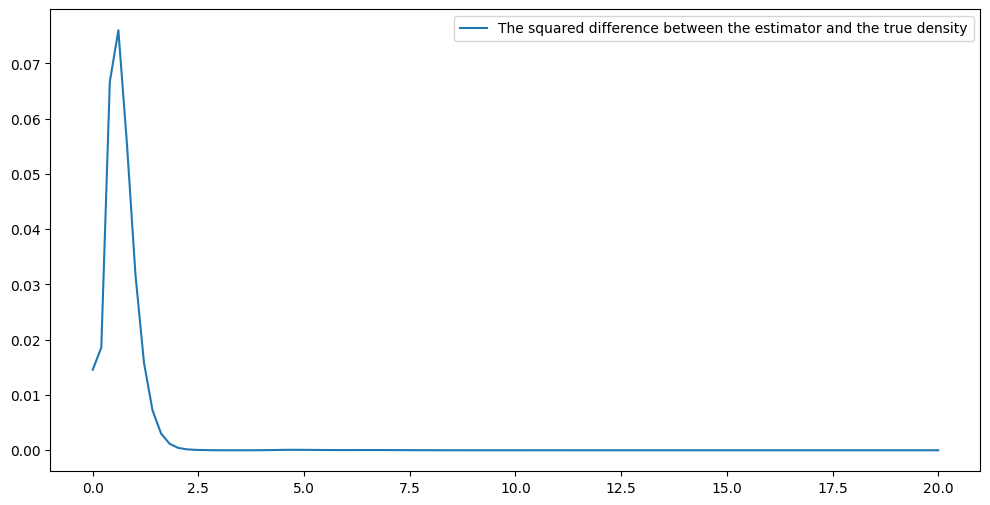

In [100]:
# compute MISE between kernel estimated density and true exponential density
h = 0.7
f = lambda x: np.exp(-x)
g = lambda x: kde_gauss(inter, h, x)
print("The $L^2$ norm of the difference is : ", L_2(f, g, 0, np.inf))

# Plotting the squared difference between the estimator and the true density
plt.figure(figsize = (12, 6))
t = np.linspace(0, 20, 100)
plt.plot(t, (g(t) - f(t))**2, label = 'The squared difference between the estimator and the true density')
plt.legend()
plt.show()

In [101]:
#computing our R_2 score
X = np.random.exponential(scale = 1, size = 10000)
R_2_estimated = R_2(f, g, X)
print("The determination coefficient for our estimation is", R_2_estimated)

The determination coefficient for our estimation is 0.645571719749382


#### $$\mathcal{Conclusion}$$

The $L^2$ norm between the two functions is so small, therefore we can conclude that the inter-arrivals are of follwing an exponential density $\mathcal{E}(1)$.

The determination coefficient is bigger than 0,5 so it indicates that our model is useful. That's to say, thanks to our data we can generate an exponential law but there is still room for improvement as it's less than 0,8.

----

## Fourth method: Computing the Kullback-Leibler divergence

We know that the Kullback-Leibler divergence is a non-negative metric that measures how much two probability distributions $\mu$ and $\pi$ are far from each other. Its expression is given by:

$$ KL(\mu | \pi) = \int \log(\frac{\mu(x)}{\pi(x)}) \mu(x) dx $$

The KL divergence has this nice property that it is non-negative:
$$ KL(\mu | \pi) \geq 0 $$
And $$ KL(\mu | \pi) = 0 \Longleftrightarrow \mu = \pi $$

Therefore, to show that the inter-arrivals $(\xi_i)_{i \in {1, .., N}}$ follow an exponential law $\mathcal{E}(1)$, we should compute the KL divergence between the density of these random variables which we denote $\mu$, and the target density $\pi$ which is the exponential density of parameter 1, i.e :
$$ \pi(x) = e^{-x} \mathbb{1}_{x \geq 0} $$

And to estimate $\mu$, we can use the Kernel estimation of the density of the random variables $(\xi_i)_{i \in {1, .., N}}$, which means that:
$$ \mu(x) = \frac{1}{N h} \sum_{i = 1}^{N} K \left(\frac{\xi_i - x}{h} \right)  $$

where $h > 0$ is called the window of the kernel. We can take the Gaussian kernel for example, which is given by:
$$ K(x - y) = \exp \{- \sigma (x - y)^2 \}  $$

We can take $\sigma = 1$ (because we can control this variable using $h$).

Using these expressions, we can now compute the KL divergence: 
$$ KL(\mu | \pi) = \int (log(\mu(x)) + x) \mu(x) \mathrm{d}x $$


In [94]:
# The Kullback-Leibler divergence
def KL(X, h):
    g = lambda x: (np.log(kde_gauss(X, h, x)) + x) * kde_gauss(X, h, x)
    return integrate.quad(g, 0, 20)[0]

def integrand_KL(X, h, t):
    return (np.log(kde_gauss(X, h, t)) + t) * kde_gauss(X, h, t)
    

#### Let us first plot these quantitites

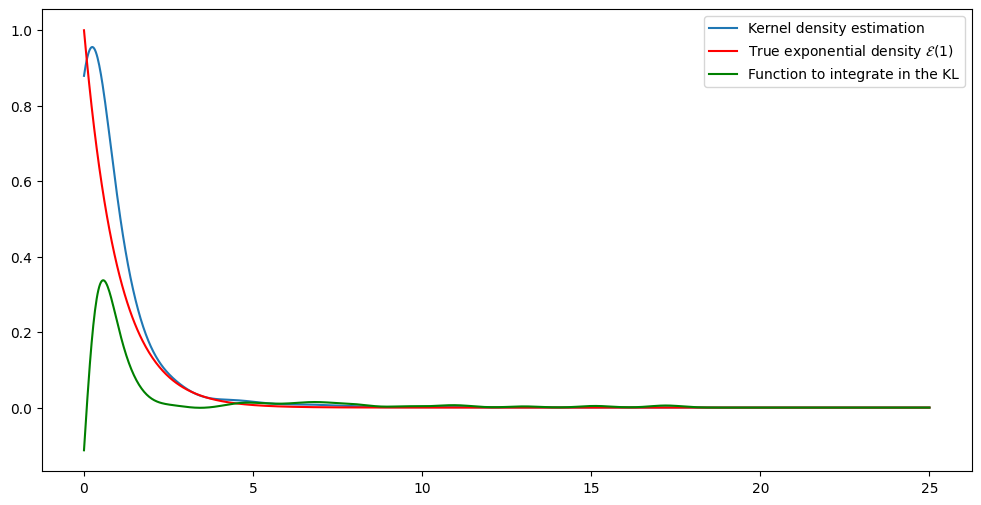

In [95]:
# Plotting the kernel density estimation
h = 0.7
plt.figure(figsize=(12, 6))
t = np.linspace(0, 25, 1000)
plt.plot(t, kde_gauss(inter, h, t), label = 'Kernel density estimation')

# Plotting the true exponential density
f = lambda x: np.exp(-x)
plt.plot(t, f(t), c = 'r', label = 'True exponential density $\mathcal{E}(1)$')

# Plotting the quantity inside the integral of the KL
plt.plot(t, integrand_KL(inter, h, t), c = 'g', label = 'Function to integrate in the KL')
plt.legend()
plt.show()

#### Prior observation:
We observe that the quantity $ x \mapsto (\log(\mu(x)) + x) \mu(x)$ becomes null when $x$ becomes larger than $20$. Hence, instead of integrating it from $0$ to $+ \infty$, we can integrate it only from $0$ to $20$. This will decrease the complexity of our method and give a very good approximation of the theoretical KL.

In [96]:
# Paramters
h = 0.7

# The value of the KL divergence
kl = KL(inter, h)
print(kl)

0.4157773938984415


#### $$\mathcal{Conclusion}$$
The value of the KL divergence is small (since it ranges from $0$ and can reach infinity under some conditions), then $\mu \approx \pi$. We can conclude that the random variables $(\xi_i)_{i \in \{1, ..., N \}}$, are of exponential law of parameter 1, ($\mathcal{E}(1)$).

----

## Comment on the project:
In the task of maximizing the likelihood, if we use the same optimization method ("Nelder-Mead") but with different initilization point, like (0.1, 0.1, 0.1), we find another values for $\alpha$, $\beta$ and $\gamma$, which are:


In [105]:
# Paramaters
x0 = (0.1, 0.1, 0.1)
T = l
t = T[-1]

# The constraint beta < gamma
constraint = LinearConstraint([0, -1, 1], lb = 0, ub=np.inf, keep_feasible = False)

# Optimization
res = minimize(negative_log_likelihood, x0, method = "Nelder-Mead", args = (T, t),constraints = constraint,  bounds = ((0, None), (0, None),(0,None)), tol = 1e-30)
print("The optimal parameters are : \n ")
print("alpha : ", res.x[0])
print("Beta : ", res.x[1])
print("Gamma : ", res.x[2])
print("the maximum is :", log_likelihood(T, t, res.x[0], res.x[1], res.x[2])) 

The optimal parameters are : 
 
alpha :  0.04299780154545965
Beta :  0.04500509591131226
Gamma :  0.049503404868733336
the maximum is : 1568.4445836260197


We remark that they do not maximize the likelihood, in fact, the algorithm converges to a local maximum of the log-likelihood, and not to the global one. However, we remark that we get approximatly the same performances with these values of $\alpha$, $\beta$ and $\gamma$ as of the ones that we got for the global maximum.

And if we plot $\dot{y}$ we get:

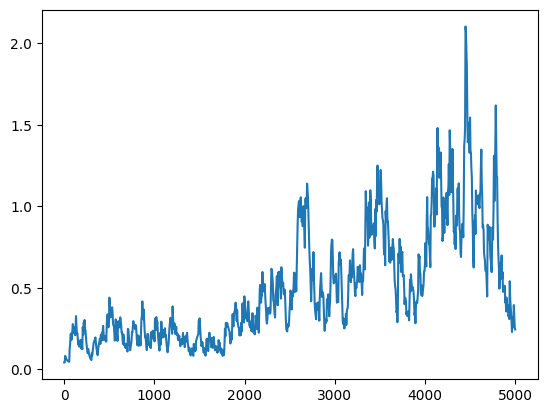

In [106]:
p = np.linspace(0, 5000, 1000)
TT = [y_dot(t, T, res.x[0], res.x[1], res.x[2]) for t in p]
plt.plot(p, TT)

By observing this plot of $\dot{y}$, we think that it model more our Hawkes process, because we observe that in the beginning, the intensity is small, so the times of occurence of Hacks do not increase heavily, and that in the middle, they begin to spread out more as we observe also that the intensity $\dot{y}$ increases (for t between 2500 and 4500). Hence, this $\dot{y}$ is more natural than the previous one.

In [108]:
def y_sec(t, T, alpha, beta, gamma):
    return integrate.quad(lambda x: y_dot(x, T, alpha, beta, gamma) , 0, t)[0]
def yy(u,t, T, alpha, beta, gamma):
    return integrate.quad(lambda x: y_dot(x, T, alpha, beta, gamma) , u, t)[0]

def process_sec(T, alpha, beta, gamma):
    Y = [y_sec(T[0], T, alpha, beta, gamma)]
    for i in range(1,len(T)):
        Y.append(yy(T[i-1],T[i], T, alpha, beta, gamma)+Y[-1])
    return np.array(Y)

def inter_arrivals_sec(Y):
    return Y[1 :] - Y[ : -1]
YY = process_sec(T, res.x[0], res.x[1], res.x[2])
interr = inter_arrivals_sec(Y)
print(YY)
print(interr)

[3.43982412e-01 3.27962140e+00 3.54517671e+00 ... 2.52586416e+03
 2.52862793e+03 2.53099992e+03]
[17.18702141  1.05226662  1.7537777  ...  0.35075554  7.01511078
  8.0673774 ]


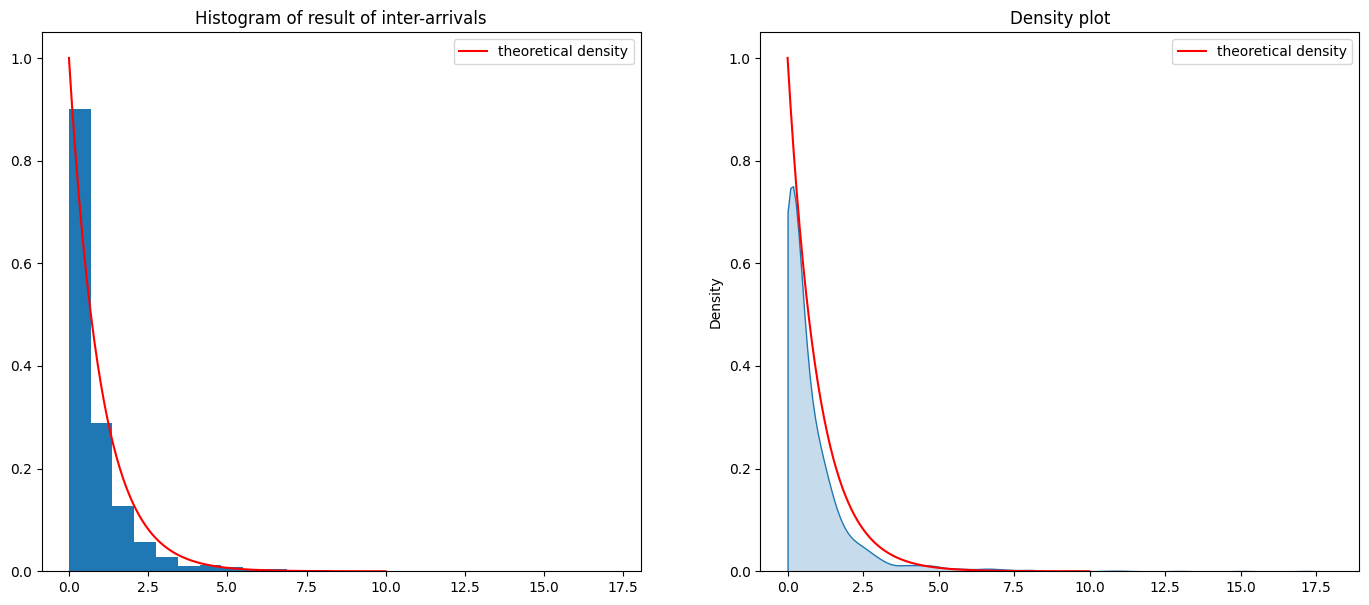

In [109]:
f = lambda x: np.exp(-x)
t = np.linspace(0, 10, 100)

# Plotting the comparisoon between densities
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(interr, density = True, bins = 25)
axs[0].set_title('Histogram of result of inter-arrivals')
axs[0].plot(t, f(t), label = 'theoretical density', c = 'r')
axs[0].legend()

# Plot the True density
sns.kdeplot(data = interr, fill=True, ax=axs[1], bw_method='silverman', clip=(0, None))
axs[1].plot(t, f(t), label = 'theoretical density', c = 'r')
axs[1].set_title('Density plot')
axs[1].legend()

# Show the plot
plt.show()

Therefore, for these values of $\alpha$, $\beta$ and $\gamma$, we obtain inter-arrivals of exponential law of intensity 1 as well ! And if we do again the Kolmogorov test, we obtain:

In [112]:
# Sort the array
sorted_interr = sorted(interr)
n = len(sorted_interr)

# calculate the test statistic
test_statistic2 = 0
for j in range(n):
    max_val = max((j + 1) / n - expon.cdf(sorted_interr[j], scale = 1), expon.cdf(sorted_interr[j], scale = 1) - j / n)
    if max_val >= test_statistic2:
        test_statistic2 = max_val
print("The value of our test statistic is : ", test_statistic2)

The value of our test statistic is :  0.3765310154089293


In [113]:
#calculate the p-value
p_value2 = 1.0 - expon.cdf(test_statistic2)

# Print the test results
print("Test statistic: ",test_statistic2)
print("P-value: " , p_value2)

Test statistic:  0.3765310154089293
P-value:  0.6862378334096746


And the $R^2$ score is:

In [125]:
#computing our R_2 score
X = np.random.exponential(scale = 1, size = 10000)
g2 = lambda x: kde_gauss(interr, 0.7, x)
R_2_estimated2 = R_2(f, g2, X)
print("The determination coefficient for our estimation is", R_2_estimated2)

The determination coefficient for our estimation is 0.644756522603064


# Thank you